In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#*from matplotlib.patches import Ellipse , Rectangle
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import f # F分布相关的api
from scipy.stats import norm # 标准正太的api
from scipy.stats import chi2 # 卡方分布的api
from scipy.stats import t # t分布的api

import json
import re

from math_packages import distance
from math_packages import static_test
from math_packages import static_plt
#*----------------------------------------------------------------
mpl.rcParams['font.sans-serif'] = ['SimHei'] # *允许显示中文
plt.rcParams['axes.unicode_minus']=False# *允许显示坐标轴负数
#*----------------------------------------------------------------

params = {'legend.fontsize': 7,}

plt.rcParams.update(params)

# 数据的读入

In [28]:
file = open("data//OriginalData.json" , 'r' , encoding='utf-8')
original_data = json.load(file)
file.close()

In [29]:
print(original_data[0])
len(original_data)

{'片名': '肖申克的救赎 The Shawshank Redemption', '导演': '弗兰克·德拉邦特', '编剧': ['弗兰克·德拉邦特', '斯蒂芬·金'], '主演': ['蒂姆·罗宾斯', '摩根·弗里曼', '鲍勃·冈顿', '威廉姆·赛德勒', '克兰西·布朗', '吉尔·贝罗斯', '马克·罗斯顿', '詹姆斯·惠特摩', '杰弗里·德曼', '拉里·布兰登伯格', '尼尔·吉恩托利', '布赖恩·利比', '大卫·普罗瓦尔', '约瑟夫·劳格诺', '祖德·塞克利拉', '保罗·麦克兰尼', '芮妮·布莱恩', '阿方索·弗里曼', 'V·J·福斯特', '弗兰克·梅德拉诺', '马克·迈尔斯', '尼尔·萨默斯', '耐德·巴拉米', '布赖恩·戴拉特', '唐·麦克马纳斯'], '类型': ['剧情', '犯罪'], '制片国家/地区': ['美国'], '语言': ['英语'], '上映日期': ['1994-09-10(多伦多电影节)', '1994-10-14(美国)'], '片长': ['142分钟'], '评分': '9.7', '评价人数': '2568415'}


250

# 主要任务

我关心的是豆瓣的评分，排名，评价人数关于其余的各个变量的关系，是否有关系，关系是什么，到底是什么关系，等等

# 数据清洗

<font size = 4> 介于编剧和主演的多样性，并不能嵌入pandas进行数据分析，所以我们单把这两个数据拿出来，并根据剩下的数据进行归类</font>

<font size = 3>首先，我们发现，评分和评价人数对每个影片是唯一的，所以我们将这两项数据先单独拿出来构建dataframe</font>
<font size = 3>随后，对每个类型、国家、语言、上映时间还有片长做表格分类</font>

In [30]:
df_judge = pd.DataFrame(columns=['排名' , '片名' , '评分' , '评价人数'])
for index , film in enumerate(original_data):
    df_judge.loc[index] = [float(index + 1) , film['片名'] , float(film['评分']) , float(film['评价人数'])]

In [31]:
index = 0
df_types = pd.DataFrame(columns = ['排名' , '片名' , '类型' , '评分' , '评价人数'])
for rank , film in enumerate(original_data):
    for i in film['类型']:
        df_types.loc[index] = [float(rank + 1) , film['片名'] , i , float(film['评分']) , float(film['评价人数'])]
        if(i == '普通话'): print(i)
        index += 1

In [32]:
index = 0
df_countries_areas = pd.DataFrame(columns = ['排名' , '片名' , '国家与地区' , '评分' , '评价人数'])
for rank , film in enumerate(original_data):
    for area in film['制片国家/地区']:
        if '大陆' in area or '香港' in area or '台湾' in area:
            area = '中国'
        if '戛纳' in area:
            area = '法国'
        df_countries_areas.loc[index] = [float(rank + 1) , film['片名'] , area , float(film['评分']) , float(film['评价人数'])]
        index += 1

In [33]:
index = 0
df_languages = pd.DataFrame(columns = ['排名' , '片名' , '语言' , '评分' , '评价人数'])
for rank , film in enumerate(original_data):
    for language in film['语言']:
        df_languages.loc[index] = [float(rank + 1) , film['片名'] , language , float(film['评分']) , float(film['评价人数'])]
        index += 1

In [34]:
index = 0
df_times = pd.DataFrame(columns = ['排名' , '片名' , '上映日期' , '评分' , '评价人数'])
for rank , film in enumerate(original_data):
    for time in film['上映日期']:
        df_times.loc[index] = [float(rank + 1) , film['片名'] , int(time[0:4]) , float(film['评分']) , float(film['评价人数'])]
        index += 1

In [35]:
index = 0
df_lens = pd.DataFrame(columns = ['排名' , '片名' , '片长' , '评分' , '评价人数'])
for rank , film in enumerate(original_data):
    for lens in film['片长']:
        df_lens.loc[index] = [float(rank + 1) , film['片名'] , int(re.findall('\d+', lens)[0]) , float(film['评分']) , float(film['评价人数'])]
        index += 1

# 描述性统计
首先粗浅看一下各个数据的关系

## 评分和评价人数

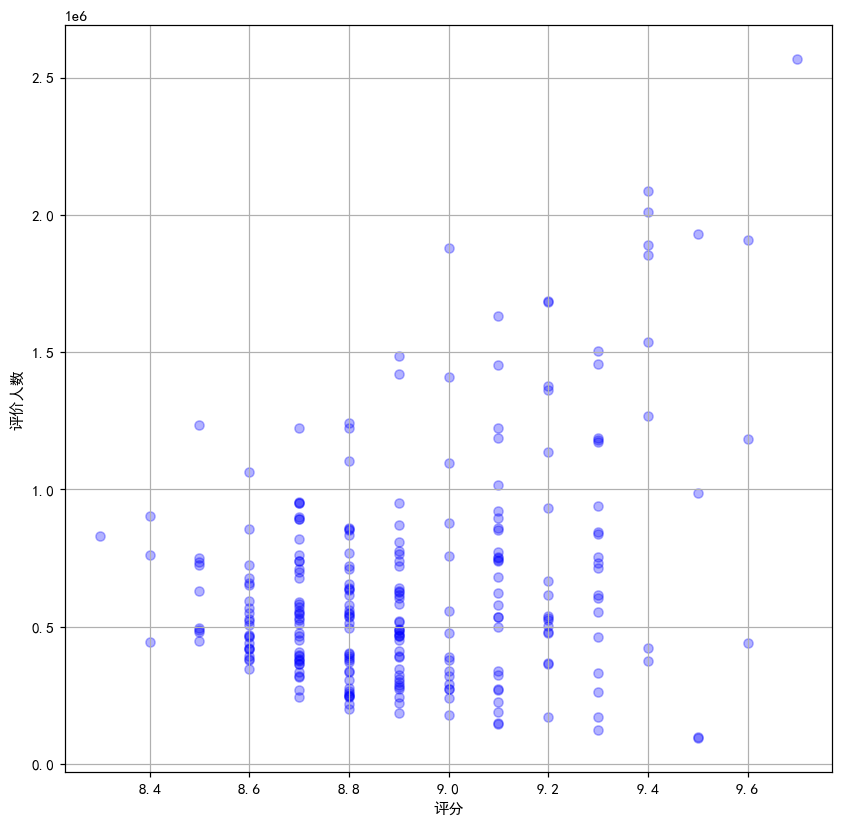

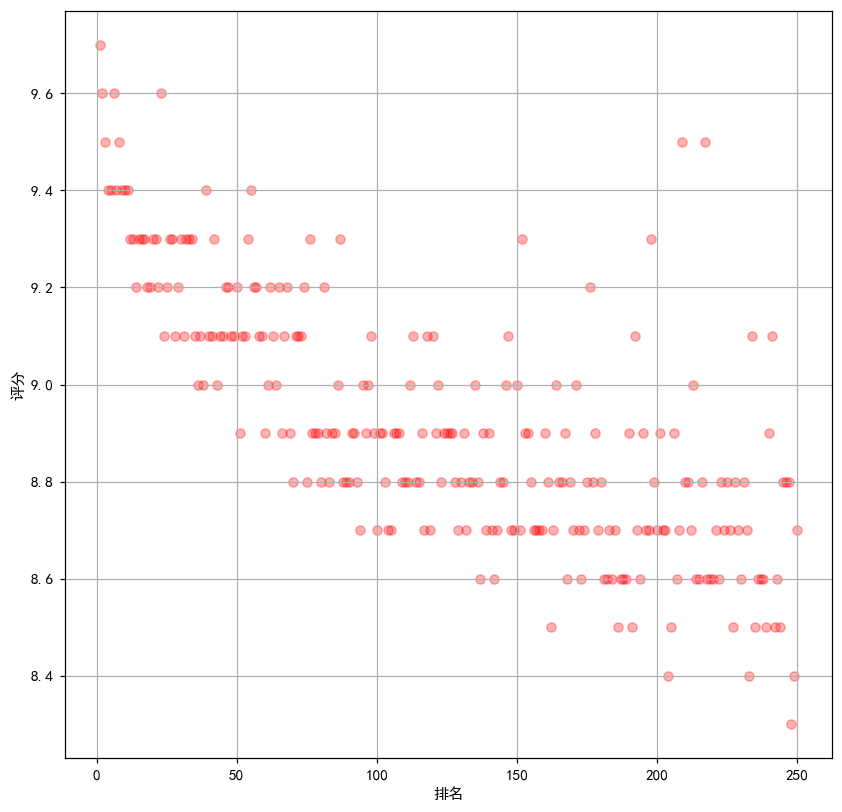

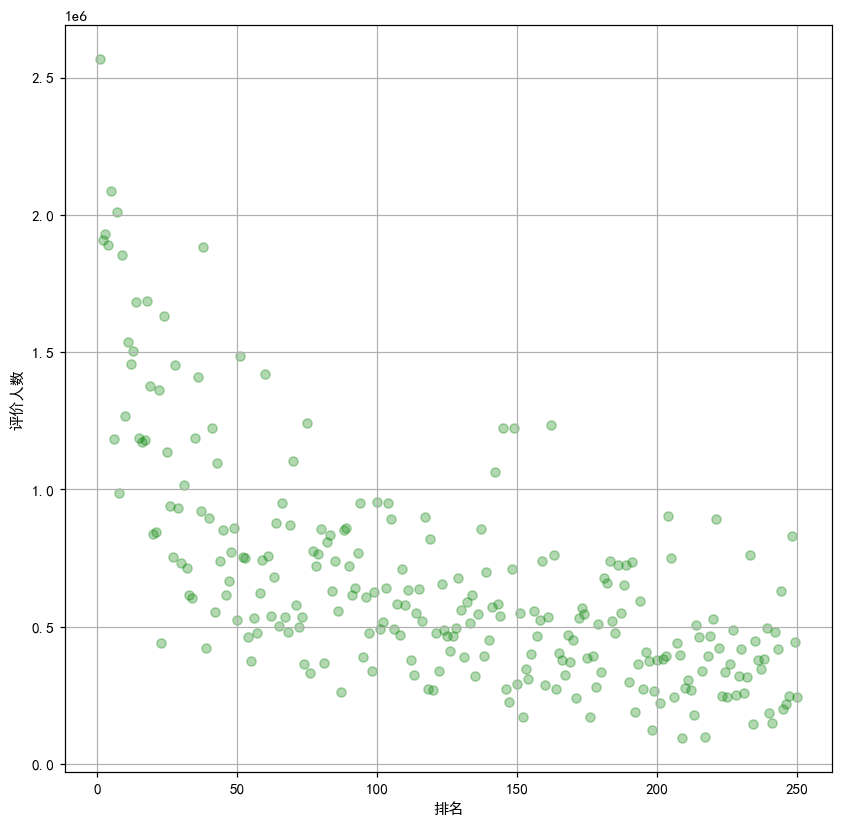

C:\Users\16252\AppData\Local\Temp/ipykernel_11984/1575473001.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_judge.loc[:,['评分','评价人数']].hist(bins =50 , figsize=(9,9) , ax = axes)


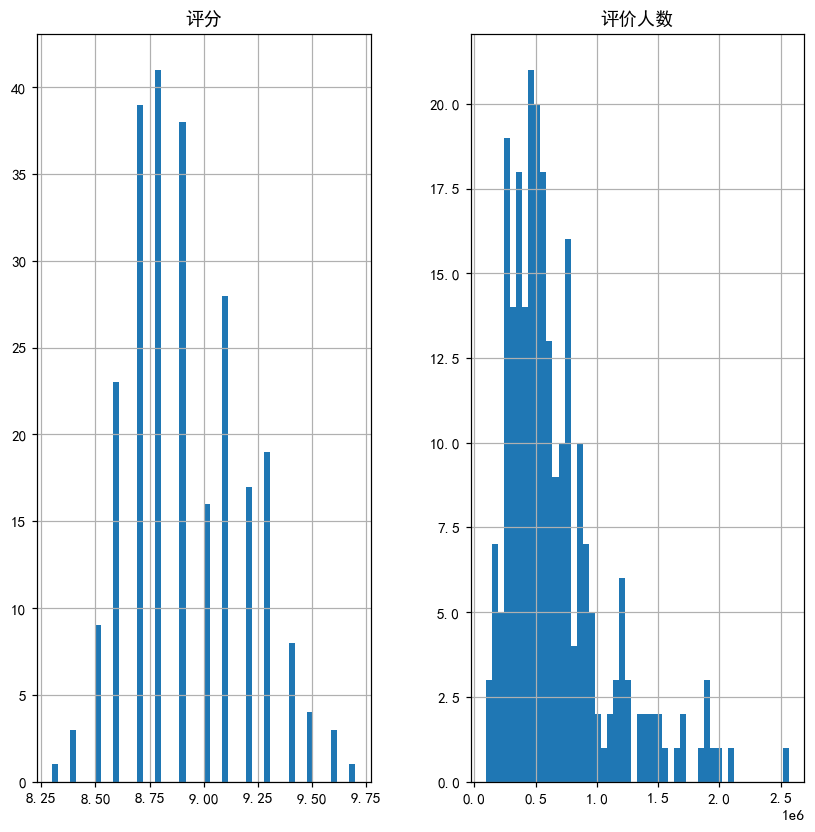

In [36]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
axes.scatter(df_judge.loc[: , '评分'] , df_judge.loc[: , '评价人数'] , color = 'blue' , alpha = 0.3)
axes.set_xlabel('评分') ; axes.set_ylabel('评价人数') ; axes.grid()
plt.savefig('images/describe/评分_评价人数_排名.jpg')
plt.show()

fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
axes.scatter(df_judge['排名'] , df_judge['评分'] , color = 'red' , alpha = 0.3)
axes.set_xlabel('排名') ; axes.set_ylabel('评分') ; axes.grid()
plt.savefig('images/describe/排名_评分.jpg')
plt.show()

fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
axes.scatter(df_judge['排名'] , df_judge['评价人数'] , color = 'green' , alpha = 0.3)
axes.set_xlabel('排名') ; axes.set_ylabel('评价人数') ; axes.grid()
plt.savefig('images/describe/排名_评价人数.jpg')
plt.show()

fig, axes = plt.subplots(figsize = (9 , 9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
df_judge.loc[:,['评分','评价人数']].hist(bins =50 , figsize=(9,9) , ax = axes)
plt.savefig('images/describe/评分_评价人数_hist.jpg')
plt.show()

<font size = 4>那么我们能够看到，评分和评价人数的关联从直观上来讲不太明显，反倒是排名和评分，排名和评价人数之间存在一定关联  
并且根据评分和评价人数的频数统计图我们可以看到，这两个特征都有明显的后尾分布的图像，那么在分析阶段会对这两个特征的分布进行分析</font>

## 影片的类型，国家，语言

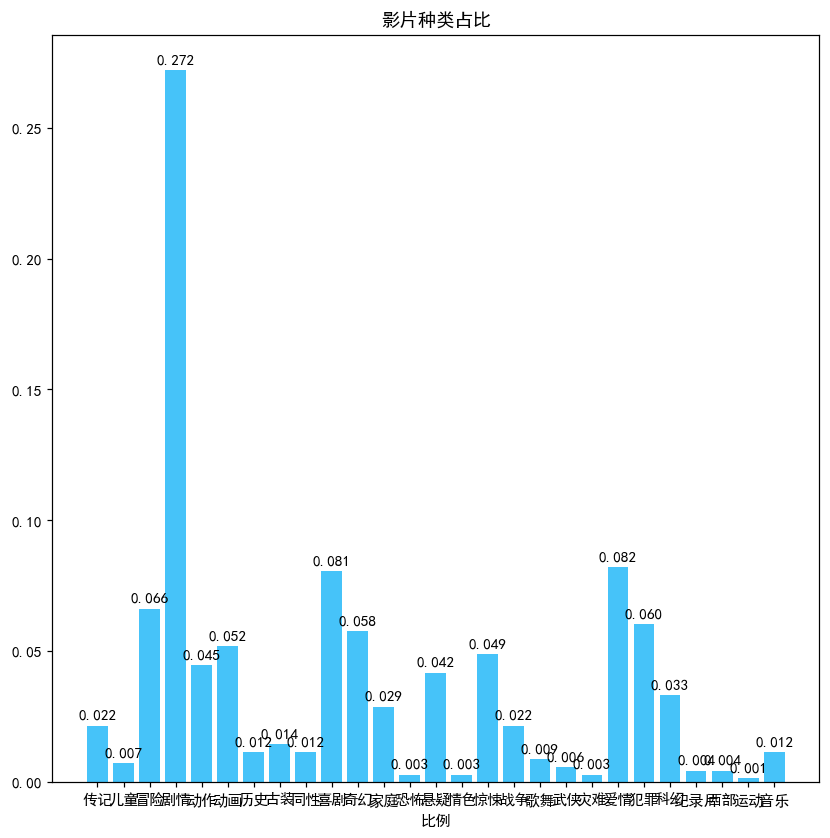

In [37]:
types = list(np.unique(df_types.loc[: , '类型']))
types_frequency = np.zeros(len(types))
for i in df_types.loc[: , '类型']:
    types_frequency[types.index(i)] += 1
types_ratio = types_frequency / np.sum(types_frequency)


fig  , axes = plt.subplots( figsize=(9,9) , dpi=110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
rect = axes.bar(types,types_ratio , color = '#46c3f9')
axes.set_title('影片种类占比') ; axes.set_xlabel('比例')

axes.bar_label(rect , padding = 3 , fmt = '%.3f')
plt.savefig('images/describe/影片种类占比.jpg')
plt.show()

<font size = 4>那么从上面所作图可以看到，剧情片的占比很高，其次是爱情片，喜剧片，那么自然而然的问题就是影片种类是否会对评分产生影响  
如果产生影响，那些类型的影片更容易获得高票数？影片种类是和否是直接影响因素，有没有间接变量？  </font>


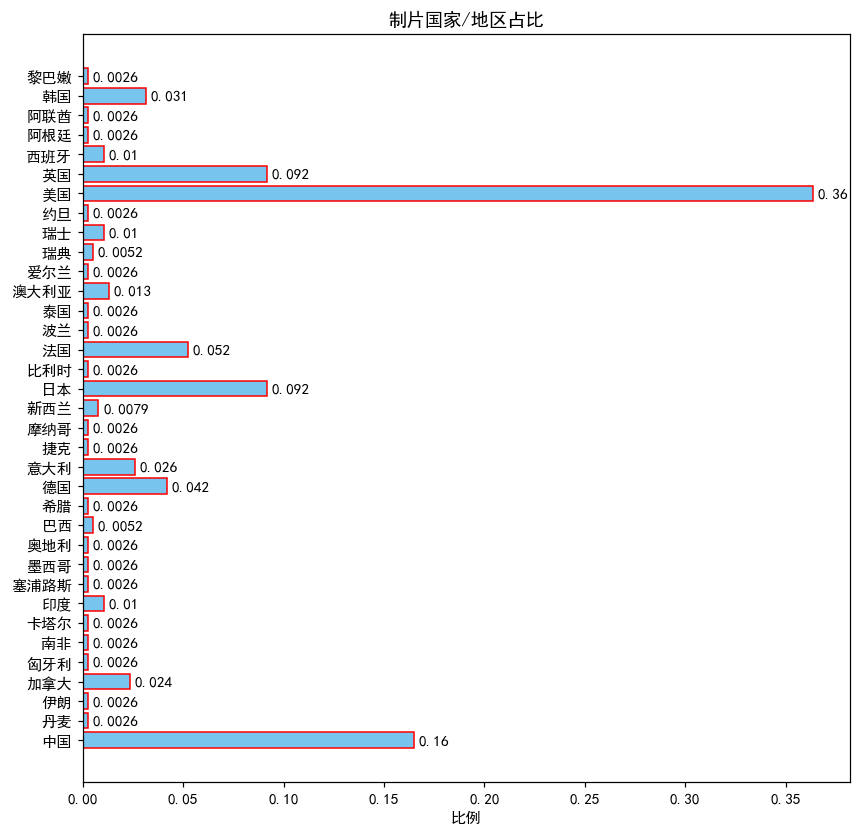

In [38]:
areas = list(np.unique(df_countries_areas.loc[: , '国家与地区']))
areas_frequency = np.zeros(len(areas))
for i in df_countries_areas.loc[: , '国家与地区']:
    areas_frequency[areas.index(i)] += 1

areas_ratio = areas_frequency/ np.sum(areas_frequency)

fig  , axes = plt.subplots( figsize=(9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
rect = axes.barh( areas , areas_ratio , color = '#77c4ee' , edgecolor = 'red')
axes.set_title('制片国家/地区占比') ; axes.set_xlabel('比例')
axes.bar_label(rect , padding = 3 , fmt='%.2g')
plt.savefig('images/describe/制片国家_地区占比.jpg')
plt.show()

<font size = 4>还是一样的问题，制片国家是否会对评分产生影响？是积极影响还是消极影响？都需要进行统计性的检验</font>

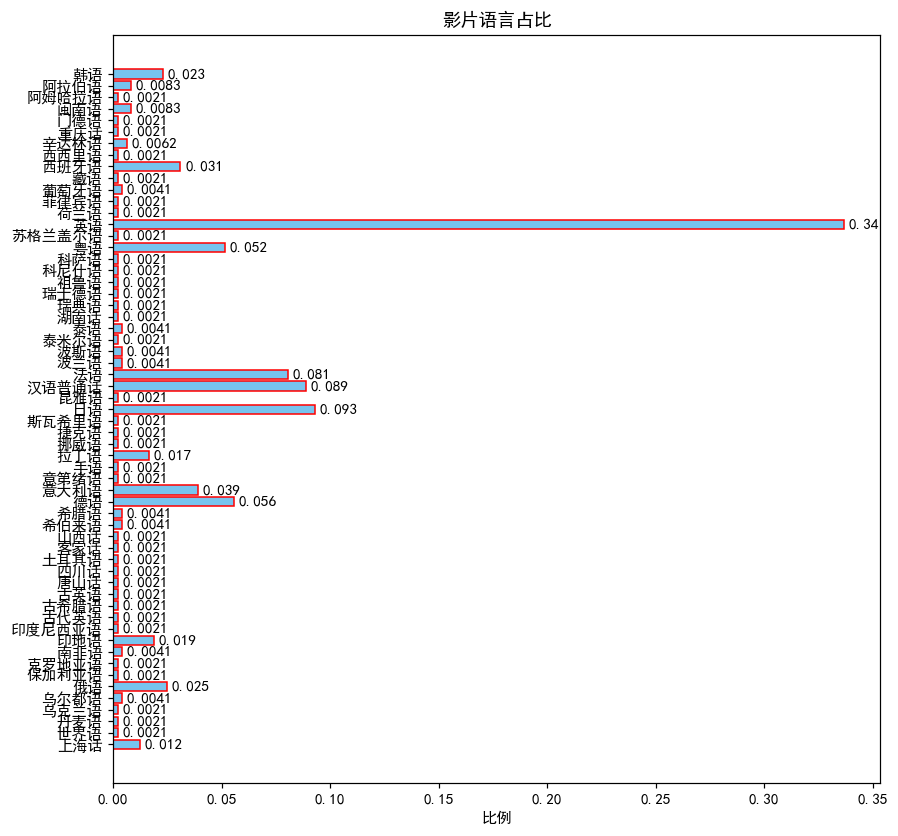

In [39]:
languages = list(np.unique(df_languages.loc[: , '语言']))
languages_frequency = np.zeros(len(languages))
for i in df_languages.loc[: , '语言']:
    languages_frequency[languages.index(i)] += 1

languages_ratio = languages_frequency/ np.sum(languages_frequency)

fig  , axes = plt.subplots( figsize=(9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
rect = axes.barh( languages , languages_ratio , color = '#77c4ee' , edgecolor = 'red')
axes.set_title('影片语言占比') ; axes.set_xlabel('比例')
axes.bar_label(rect , padding = 3 , fmt='%.2g')
plt.savefig('images/describe/影片语言占比.jpg')
plt.show()

## 影片的上映时间和时长

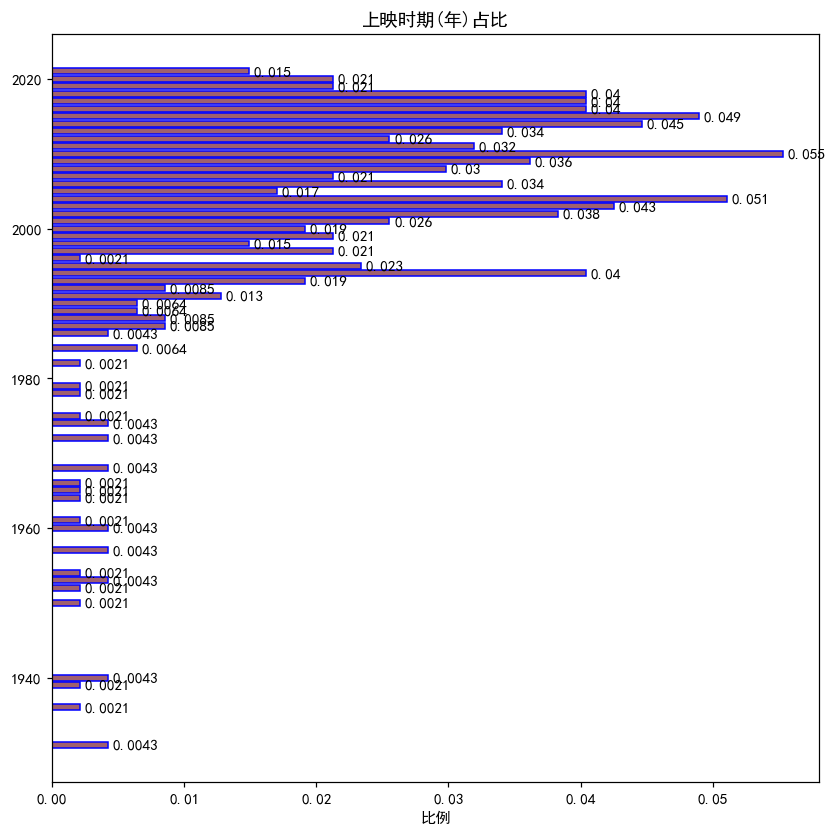

In [40]:
times = list(np.sort(np.unique(df_times.loc[: , '上映日期'])))
times_frequency = np.zeros(len(times))
for i in df_times.loc[: , '上映日期']:
    times_frequency[times.index(i)] += 1

times_ratio = times_frequency/ np.sum(times_frequency)

fig  , axes = plt.subplots(figsize=(9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
rect = axes.barh( times , times_ratio , color = '#a0606e' , edgecolor = 'blue')
axes.set_title('上映时期(年)占比') ; axes.set_xlabel('比例')
axes.bar_label(rect , padding = 3 , fmt='%.2g')
plt.savefig('images/describe/上映时期(年)占比.jpg')
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


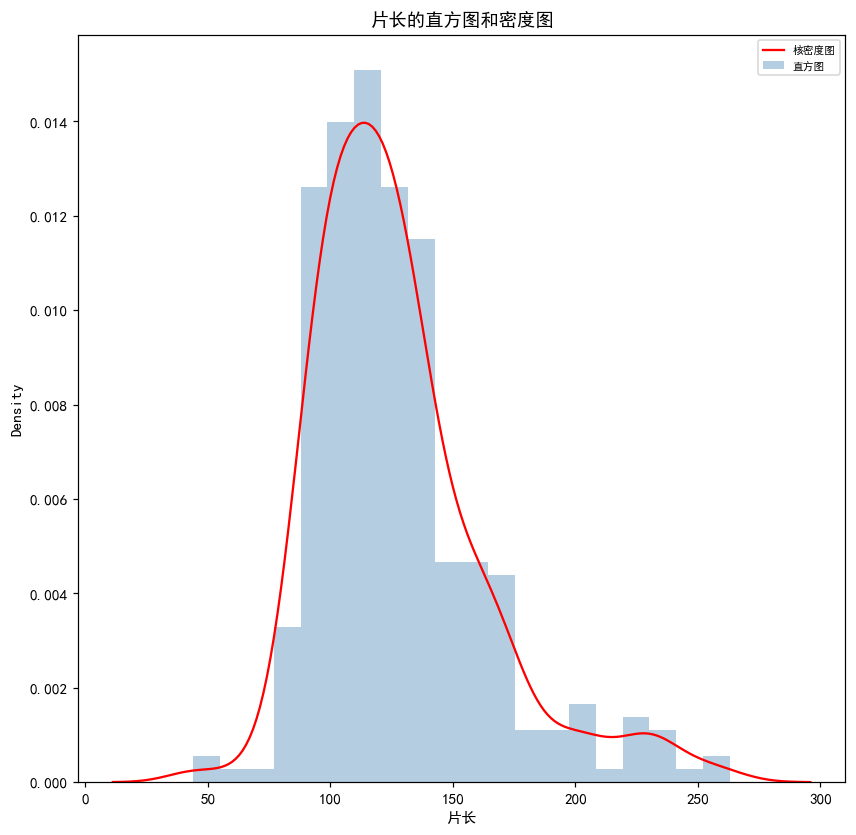

In [41]:
fig = plt.figure(figsize=(9,9),dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
sns.distplot(df_lens.loc[: , '片长'], bins = 20, kde = False, hist_kws = {'color':'steelblue'},
                label = ('直方图'),norm_hist=True)
sns.distplot(df_lens.loc[: , '片长'], hist = False, kde_kws = {'color':'red', 'linestyle':'-'},
                norm_hist = True, label = ('核密度图'))
plt.title('片长的直方图和密度图')
plt.legend()
plt.savefig('images/describe/片长的直方图和密度图.jpg')
plt.show()

那么从上述的图我们可以看到，豆瓣top250的影片上映时间大多都集中在二十一世纪前后，其中至少有50%集中在近20年  
并且片长的分布也呈现近似正态分布，下面对是不是正态分布进行进一步讨论,主要通过构造QQ图进行了解

# 数据分析

我们关心这些数据的边缘正态性，接下来就绘制对应的QQ图

## 评分与评分人数的正态性

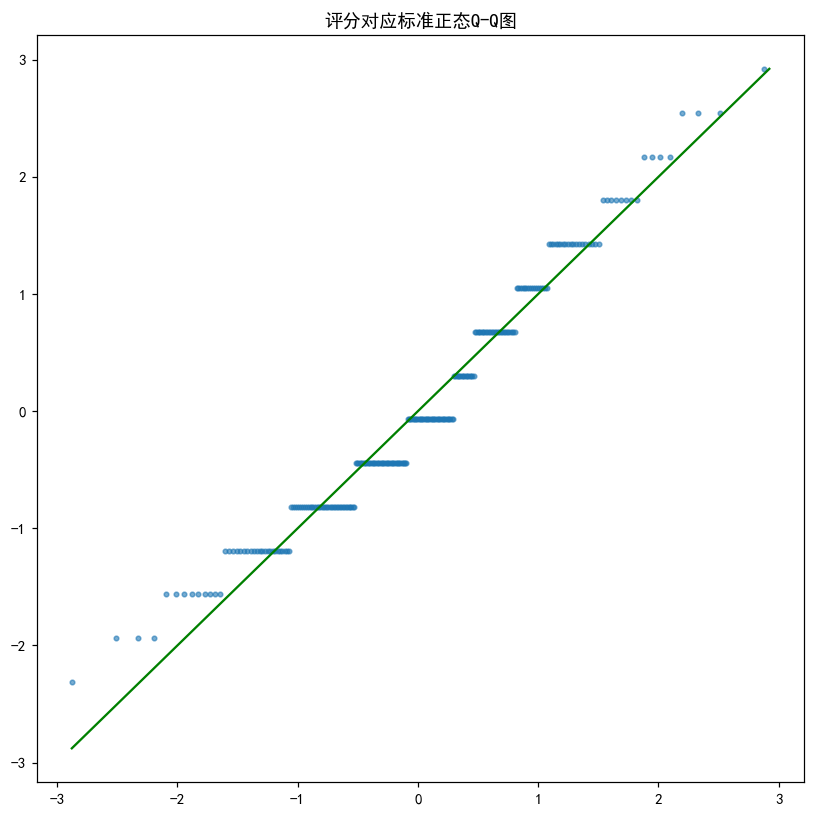

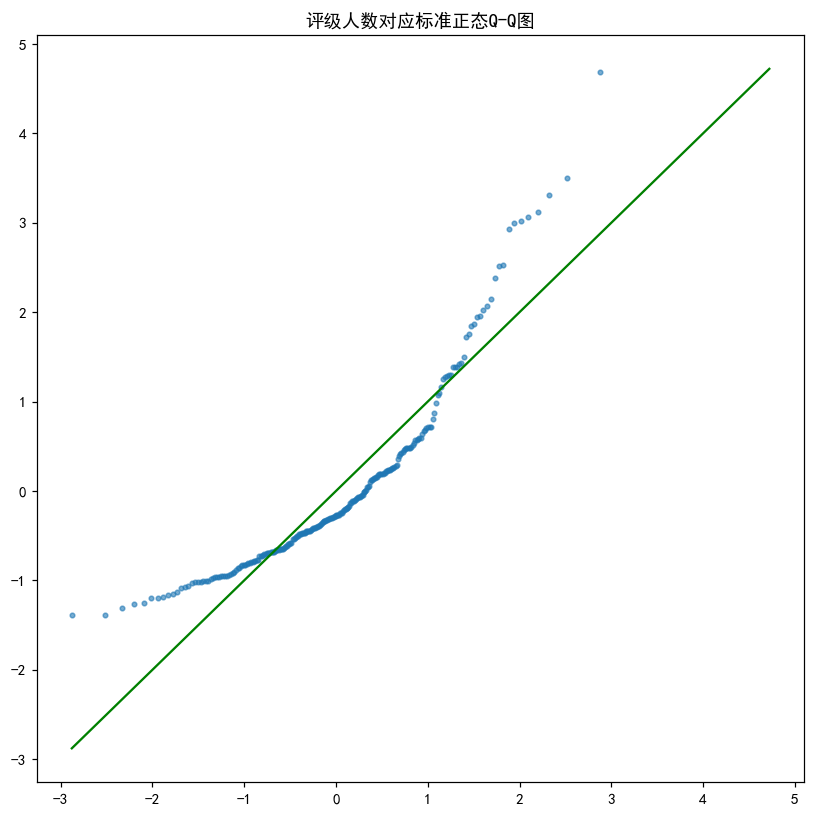

In [42]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(df_judge.loc[: , '评分'] , axes , standardized = True)
axes.set_title('评分对应标准正态Q-Q图') 
plt.savefig('images/analysis/评分对应标准正态Q-Q图')
plt.show()

fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(df_judge.loc[: , '评价人数'] , axes, standardized = True)
axes.set_title('评价人数对应标准正态Q-Q图')
plt.savefig('images/analysis/评价人数对应标准正态Q-Q图')
plt.show()

从上述的标准化后的QQ图我们可以看到，评分比较接近正态，但是评价人数人数明显偏离正态

## 其余属性变量的正态性

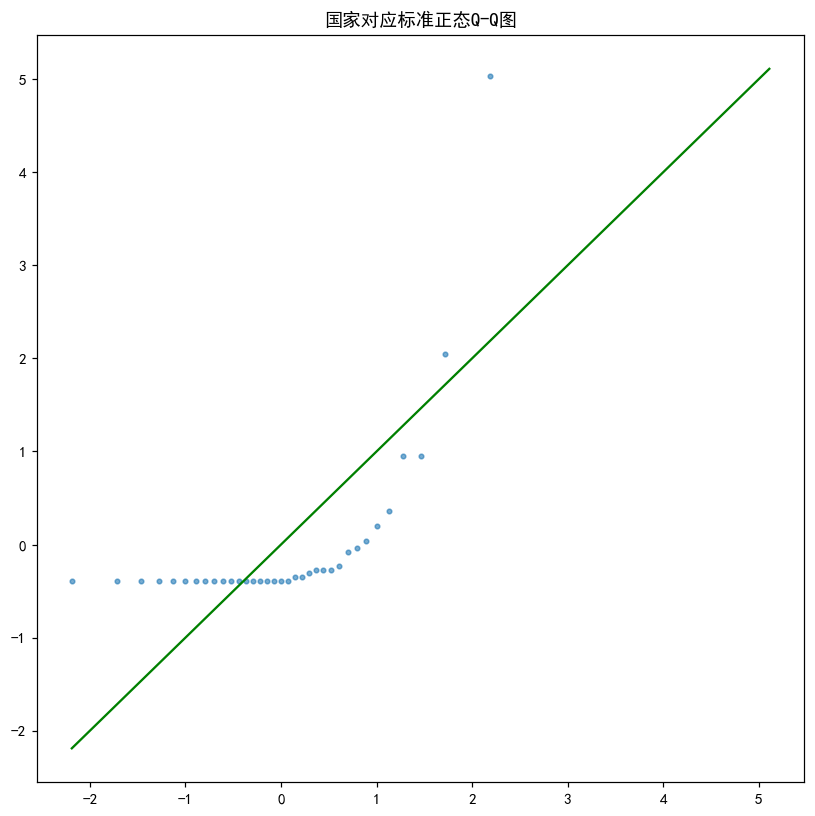

In [43]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(areas_frequency , axes, standardized = True)
axes.set_title('国家对应标准正态Q-Q图')
plt.savefig('images/analysis/国家对应标准正态Q-Q图')
plt.show()

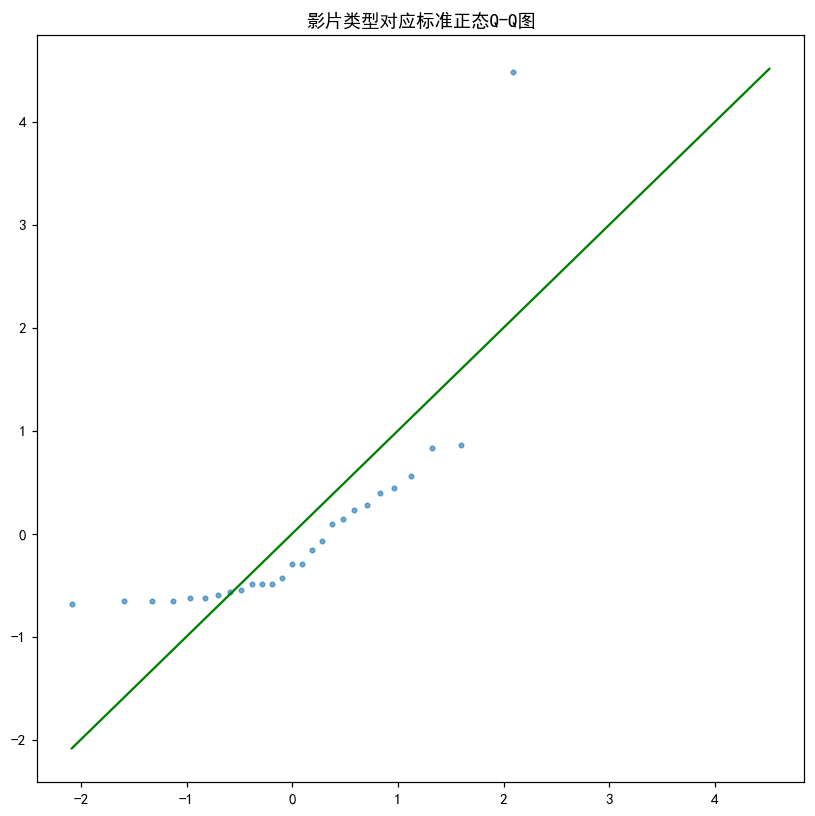

In [44]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(types_frequency , axes, standardized = True)
axes.set_title('影片类型对应标准正态Q-Q图')
plt.savefig('images/analysis/影片类型对应标准正态Q-Q图')
plt.show()

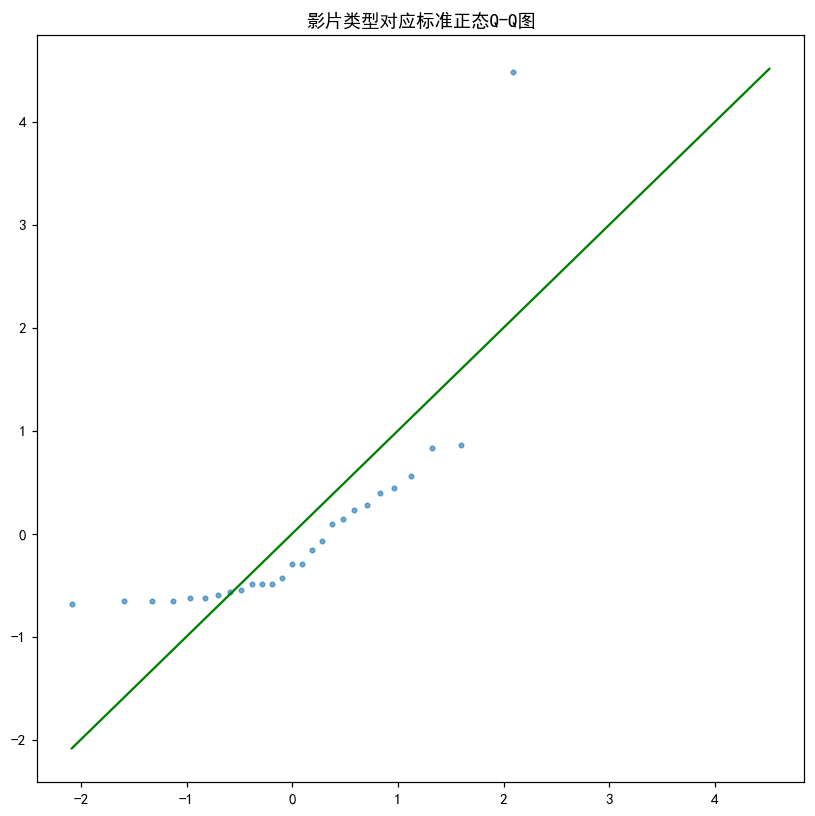

In [45]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(types_frequency , axes, standardized = True)
axes.set_title('影片类型对应标准正态Q-Q图')
plt.savefig('images/analysis/影片类型对应标准正态Q-Q图')
plt.show()

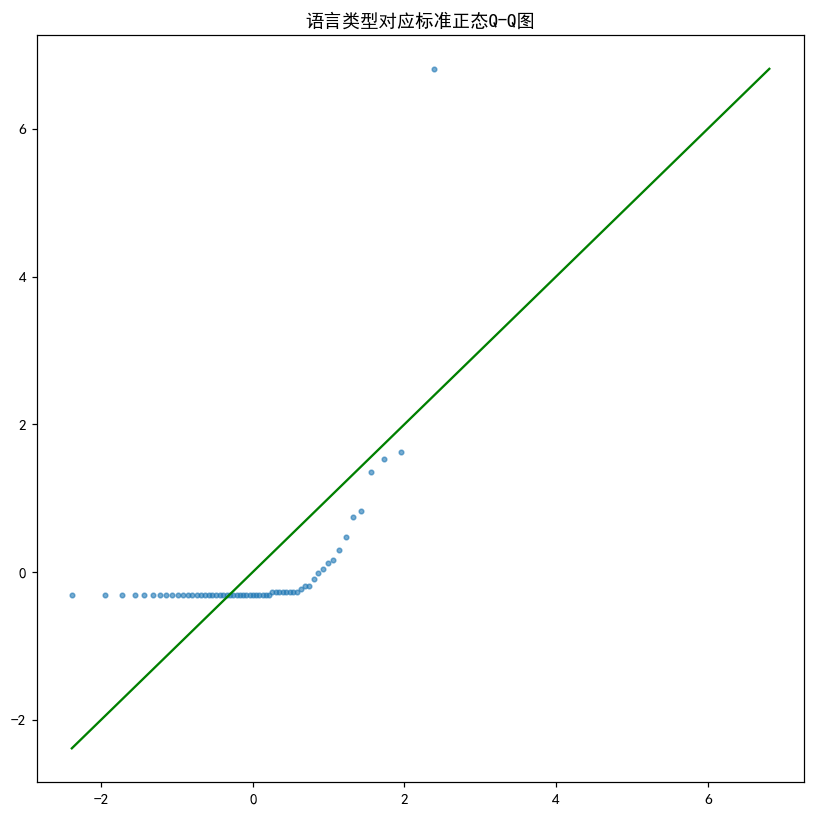

In [46]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(languages_frequency , axes, standardized = True)
axes.set_title('语言类型对应标准正态Q-Q图')
plt.savefig('images/analysis/语言类型对应标准正态Q-Q图')
plt.show()

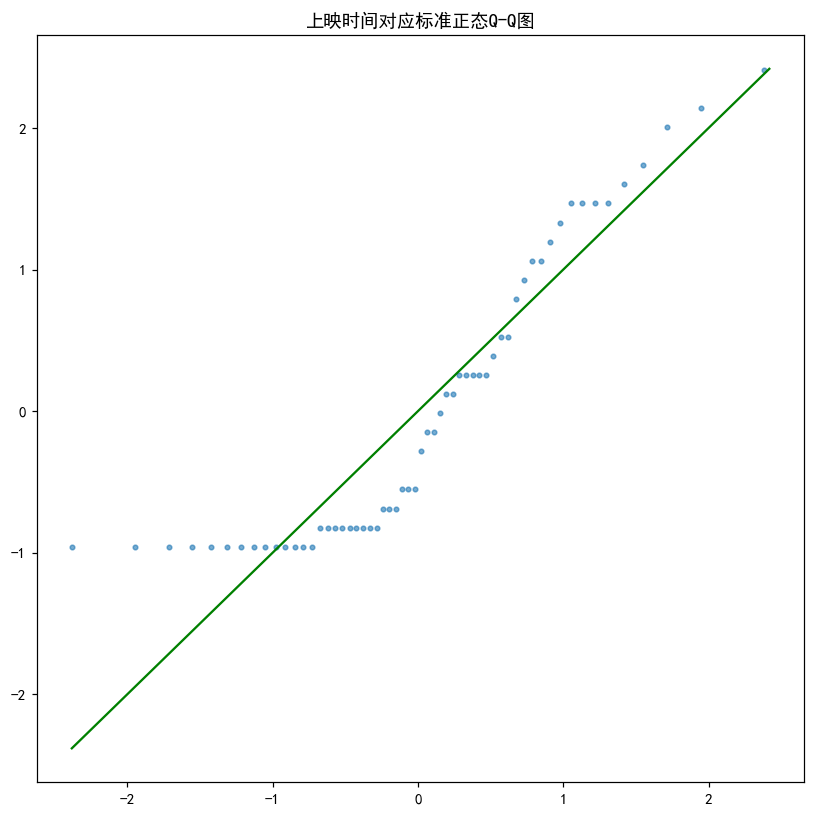

In [47]:
fig , axes = plt.subplots(figsize = (9,9) , dpi = 110)
fig.patch.set_facecolor("white") #* 设置背景 以免保存的图片背景虚化
static_plt.norm_QQ(times_frequency , axes, standardized = True)
axes.set_title('上映时间对应标准正态Q-Q图')
plt.savefig('images/analysis/上映对应标准正态Q-Q图')
plt.show()

可以看到除了评分比较正态，剩余的都不太正态